In [2]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from sklearn.utils import shuffle

import pandas as pd
from sklearn.model_selection import train_test_split
%matplotlib inline

### Data Acquisition

#### Create DataFrame

* Create dataframe with image_path, time(seconds) and speed

* In the video given, we have ~344 (5min 44s) seconds of video. 
* Our ground truth labels correspond to a video that is 12m 12s (~732seconds). 
* We only have a portion of that video. 
* It appears that our framerate <strong>~ 13 fps </strong>. (4459 frames * (1 second / 13frames) = 344 seconds)

In [3]:
df = pd.read_csv('./data/driving.csv')
df.head(10)
len(df)

4459

In [4]:
valid_data = df[3541:4459]
train_data = df[0:3540]

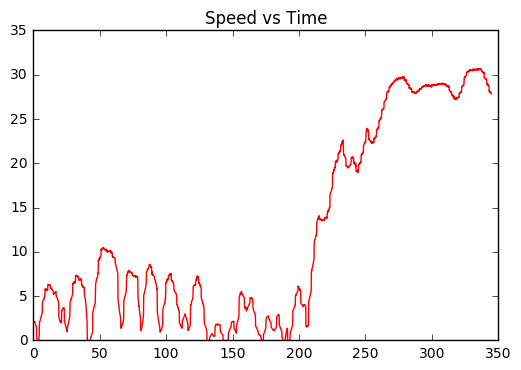

In [5]:
times = np.asarray(df['time'], dtype = np.float32)
speeds = np.asarray(df['speed'], dtype=np.float32)
plt.plot(times, speeds, 'r-')
plt.title('Speed vs Time')
plt.show()

In [6]:
df.tail(5)

,image_path,time,speed
4454,./data/IMG/344.3211498260498.jpg,344.321150,27.928958
4455,./data/IMG/344.37305998802185.jpg,344.373060,27.938640
4456,./data/IMG/344.5106108188629.jpg,344.510611,27.932405
4457,./data/IMG/344.5854048728943.jpg,344.585405,27.927574
4458,./data/IMG/344.63681387901306.jpg,344.636814,27.847842


## Train Test Split

In [7]:
df.tail(10)

,image_path,time,speed
4449,./data/IMG/343.772882938385.jpg,343.772883,28.028809
4450,./data/IMG/343.88360381126404.jpg,343.883604,28.046888
4451,./data/IMG/343.9875497817993.jpg,343.987550,27.965789
4452,./data/IMG/344.0397799015045.jpg,344.039780,28.006446
4453,./data/IMG/344.1648499965668.jpg,344.164850,27.993581
4454,./data/IMG/344.3211498260498.jpg,344.321150,27.928958
4455,./data/IMG/344.37305998802185.jpg,344.373060,27.938640
4456,./data/IMG/344.5106108188629.jpg,344.510611,27.932405
4457,./data/IMG/344.5854048728943.jpg,344.585405,27.927574
4458,./data/IMG/344.63681387901306.jpg,344.636814,27.847842


In [8]:
valid_data = df[3541:4459]
train_data = df[0:3540]

## Preprocess

In [10]:
def change_brightness(image):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    bright_factor = 0.2 + np.random.uniform()
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # perform brightness augmentation only on the second channel
    hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
    # change back to RGB
    image_rgb = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    return image_rgb

#### Perspective Transform

In [11]:
def apply_perspective_transform(image):
    pass

In [12]:
def preprocess_image(image):
    """
    preprocesses the image
    
    input: image (480 (y), 640 (x), 3) RGB
    output: image (shape is (256, 256, 3) as RGB)
    
    This stuff is performed on my validation data and my training data
    Process: 
             1) Cropping out black spots
             2) Perspective transform
             3) resize to (256, 256, 3) if not done so already from perspective transform
    """
    # Crop out sky (top) (100px) and black right part (-90px)
    image_cropped = image[100:440, :-90] # -> (380, 550, 3)
    # TODO: Write perspective transform 
#     perspective = apply_perspective_transform(image_cropped)
    
    image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    
    return image

In [13]:
def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed

In [14]:
def preprocess_image_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img = change_brightness(img)

            
    img = preprocess_image(img)
    return img, speed

### Generators

In [13]:
np.mean([10, 0])

5.0

In [14]:
def generate_training_data(data, batch_size = 32):
    image_batch = np.zeros((batch_size, 66, 220, 3)) # nvidia input params
    label_batch = np.zeros((batch_size))
    while True:
        for i in range(batch_size):
            idx = np.random.randint(len(data) - 1)
            row1 = data.iloc[[idx]].reset_index()
            row2 = data.iloc[[idx + 1]].reset_index()
            x1, y1 = preprocess_image_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            
            # preprocess another image
            x2, y2 = preprocess_image_from_path(row2['image_path'].values[0], row2['speed'].values[0])
           
            # subtract image features
            x = x1 - x2
            
            # calculate mean speed
            y = np.mean([y1, y2])
            
            image_batch[i] = x
            label_batch[i] = y
            
        yield shuffle(image_batch, label_batch)

In [15]:
def generate_validation_data(data):
    while True:
        for idx in range(len(data) - 1):
            row1 = data.iloc[[idx]].reset_index()
            row2 = data.iloc[[idx + 1]].reset_index()
            
            x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
            x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])
            
            s1 = row1['speed'].values[0]
            s2 = row2['speed'].values[0]
            
            img_diff = x1 - x2
            
            img_diff = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
            
            y = np.mean([y1, y2])
            
            speed = np.array([[y]])
            yield img_diff, speed

### Nvidia Model

In [16]:
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
tf.python.control_flow_ops = tf

N_img_height = 66
N_img_width = 220
N_img_channels = 3
def nvidia_model():
    inputShape = (N_img_height, N_img_width, N_img_channels)

    model = Sequential()
    # normalization
    model.add(Lambda(lambda x: x/ 127.5 - 1, input_shape = inputShape))

    model.add(Convolution2D(24, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv1'))
    
    model.add(ELU())    
    model.add(Convolution2D(36, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv2'))
    
    model.add(ELU())    
    model.add(Convolution2D(48, 5, 5, 
                            subsample=(2,2), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 3, 3, 
                            subsample = (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal', #gaussian init
                            name = 'conv4'))
    
    model.add(ELU())              
    model.add(Convolution2D(64, 3, 3, 
                            subsample= (1,1), 
                            border_mode = 'valid',
                            init = 'he_normal',
                            name = 'conv5'))
              
              
    model.add(Flatten(name = 'flatten'))
    model.add(ELU())
    model.add(Dense(100, init = 'he_normal', name = 'fc1'))
    model.add(ELU())
    model.add(Dense(50, init = 'he_normal', name = 'fc2'))
    model.add(ELU())
    model.add(Dense(10, init = 'he_normal', name = 'fc3'))
    model.add(ELU())
    
    # do not put activation at the end because we want to exact output, not a class identifier
    model.add(Dense(1, name = 'output', init = 'he_normal'))
    
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer = adam, loss = 'mse')

    return model

Using TensorFlow backend.


In [17]:
val_size = len(valid_data.index)
valid_generator = generate_validation_data(valid_data)
BATCH = 16
print('val_size: ', val_size)

val_size:  918


In [ ]:
model = nvidia_model()
train_size = len(train_data.index)
for i in range(6):
    train_generator = generate_training_data(train_data, BATCH)
    history = model.fit_generator(
            train_generator, 
            samples_per_epoch = 20480, # try putting the whole thing in here in the future
            nb_epoch = 6,
            validation_data = valid_generator,
            nb_val_samples = val_size)
    print(history)
    
    model.save_weights('model-weights-F2.h5')
    model.save('model-F2.h5')

Epoch 1/6
  304/20480 [..............................] - ETA: 539s - loss: 252.4227

In [ ]:
print(history.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

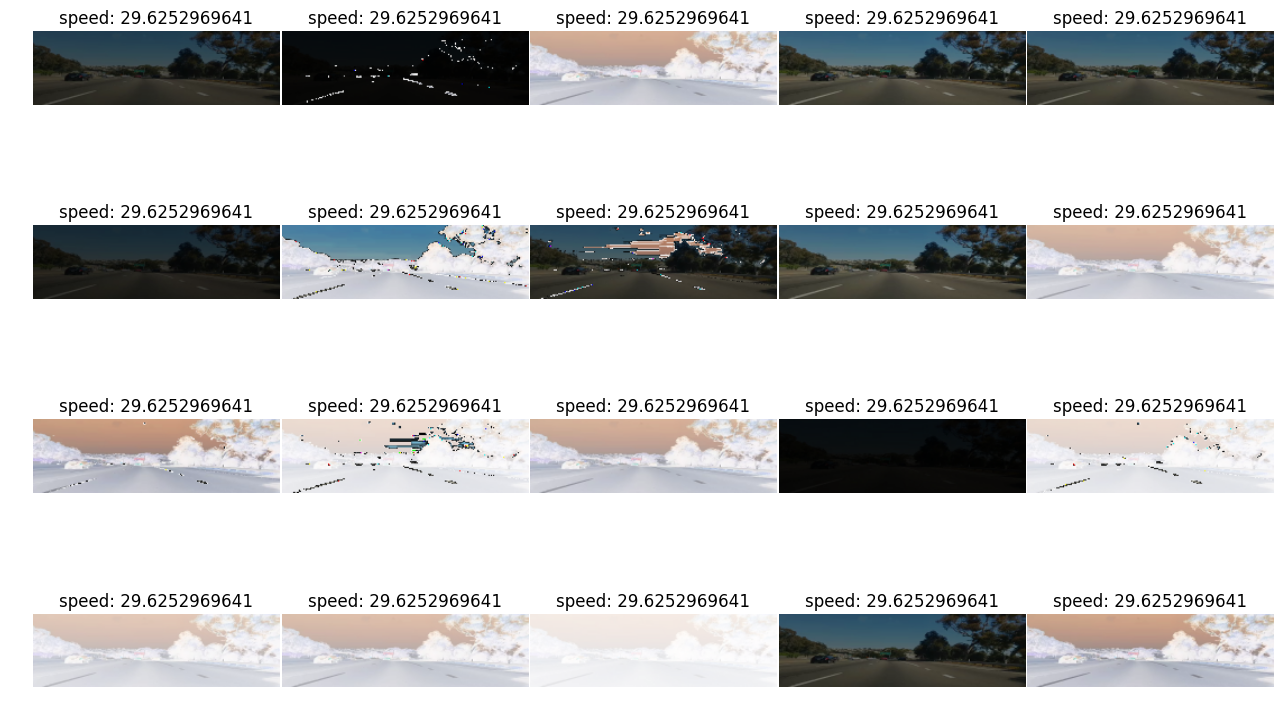

In [17]:
# random selection
data = train_data
random_images = []
for i in range(20):
    idx = np.random.randint(len(data))
    row1 = data.iloc[[idx]].reset_index()
    row2 = data.iloc[[idx + 1]].reset_index()
    x1, y1 = preprocess_image_from_path(row['image_path'].values[0], row['speed'].values[0])
    x2, y2 = preprocess_image_from_path(row['image_path'].values[0], row['speed'].values[0])
    x = x1 - x2
    y = np.mean([y1, y2])
    random_images.append((x, y))
    
plt.figure(figsize=(16, 10))
gs1 = gridspec.GridSpec(4, 5)
gs1.update(wspace = 0.01, hspace = 0.01)
for idx, image in enumerate(random_images):
    angle = 'speed: ' + str(image[1]) 
    ax1 = plt.subplot(gs1[idx])
    ax1.axis('off')
    plt.title(angle)
    plt.imshow(image[0])
plt.show()

### IDEAS: 
* Run forwards (img1 - img2) mean(speed)
* Run backwards (img2 - img1) mean(speed)
* Compute speed differential then apply prediction as: current_speed += speed_difference
* speed_difference = xW + b

* Batch shuffler
* Apply perspective transform

### Batch Shuffler

In [ ]:
def batch_shuffle(data):
    size = len(data.index)
    
    new_paths = pd.Series()
    paths = pd.Series(data['image_path'])
    
    new_times = pd.Series()
    times = pd.Series(data['time'])
    
    new_speed = pd.Series()
    speeds = pd.Series(['speed'])
    
    
    for i in range(0, size - 1):
        α = np.random.randint(0, size - 1)
        β = α + 1
        
        new_path.append

In [ ]:
def batch_shuffle(data):
    
    new_data = pd.DataFrame()
    
    for _ in range(0, len(data) - 1)
        α = np.random.randint(len(data) - 1)
        β = α + 1
        row1 = data.iloc[[α]]
        row2 = data.iloc[[β]]
        
        new_data.append
